In [1]:
from Bayesian_Neural_Network import bayesian_neural_network

import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.metrics import confusion_matrix

# Data Preparation

In [2]:
size_fraud = 100
size_non_fraud = 100

feature_data_1 = np.random.normal(loc=2, scale=0.5, size=(2, size_fraud)).T
target_data_1 = np.ones(size_fraud).reshape(-1, 1) 

feature_data_2 = np.random.normal(loc=1, scale=0.5, size=(2, size_non_fraud)).T
target_data_2 = np.ones(size_non_fraud).reshape(-1, 1) * -1

feature_data = np.concatenate((feature_data_1, feature_data_2))
target_data = np.concatenate((target_data_1, target_data_2))

In [3]:
test_size = 10
feature_data_train = np.concatenate([
                                feature_data[(target_data == 1).T[0]][:size_fraud-test_size],
                                feature_data[(target_data == -1).T[0]][:size_non_fraud-test_size],
                                ], axis=0)
target_data_train = np.concatenate([
                                target_data[(target_data == 1).T[0]][:size_fraud-test_size],
                                target_data[(target_data == -1).T[0]][:size_non_fraud-test_size]
                                ], axis=0)
feature_data_test = np.concatenate([
                                feature_data[(target_data == 1).T[0]][-test_size:],
                                feature_data[(target_data == -1).T[0]][-test_size:],
                                ], axis=0)
target_data_test = np.concatenate([
                                target_data[(target_data == 1).T[0]][-test_size:],
                                target_data[(target_data == -1).T[0]][-test_size:]
                                ], axis=0)

# Model Developments

In [16]:
input_layer = [2]
hidden_layers = [6, 6]
output_layer = [1]

total_epochs = 100
initial_lr = 5e-3
lr_decay_rate = 0.90
batch_size = 20

In [17]:
np.random.seed(10120024)

bnn = bayesian_neural_network(input_layer, 
                                hidden_layers, 
                                output_layer, 
                                feature_data_train, 
                                target_data_train, 
                                batch_size=batch_size,
                                initial_lr=initial_lr, 
                                lr_decay_rate=lr_decay_rate,
                                total_epochs=total_epochs)

In [18]:
bnn.train_model()

------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch : 1 / 100 - Learning Rate : 0.0045000000000000005 - Succesfull Train Percentage : 100.0% - Time Passed : 0.2 Second
Accuracy : 50.0% - Precision : 100.0% - Sensitivity : 50.0% - Standard Deviation : 0.8589734543187376
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch : 2 / 100 - Learning Rate : 0.004050000000000001 - Succesfull Train Percentage : 100.0% - Time Passed : 0.19 Second
Accuracy : 50.0% - Precision : 100.0% - Sensitivity : 50.0% - Standard Deviation : 0.8096245876909071
---------------------------------------------------------------------------------------------------

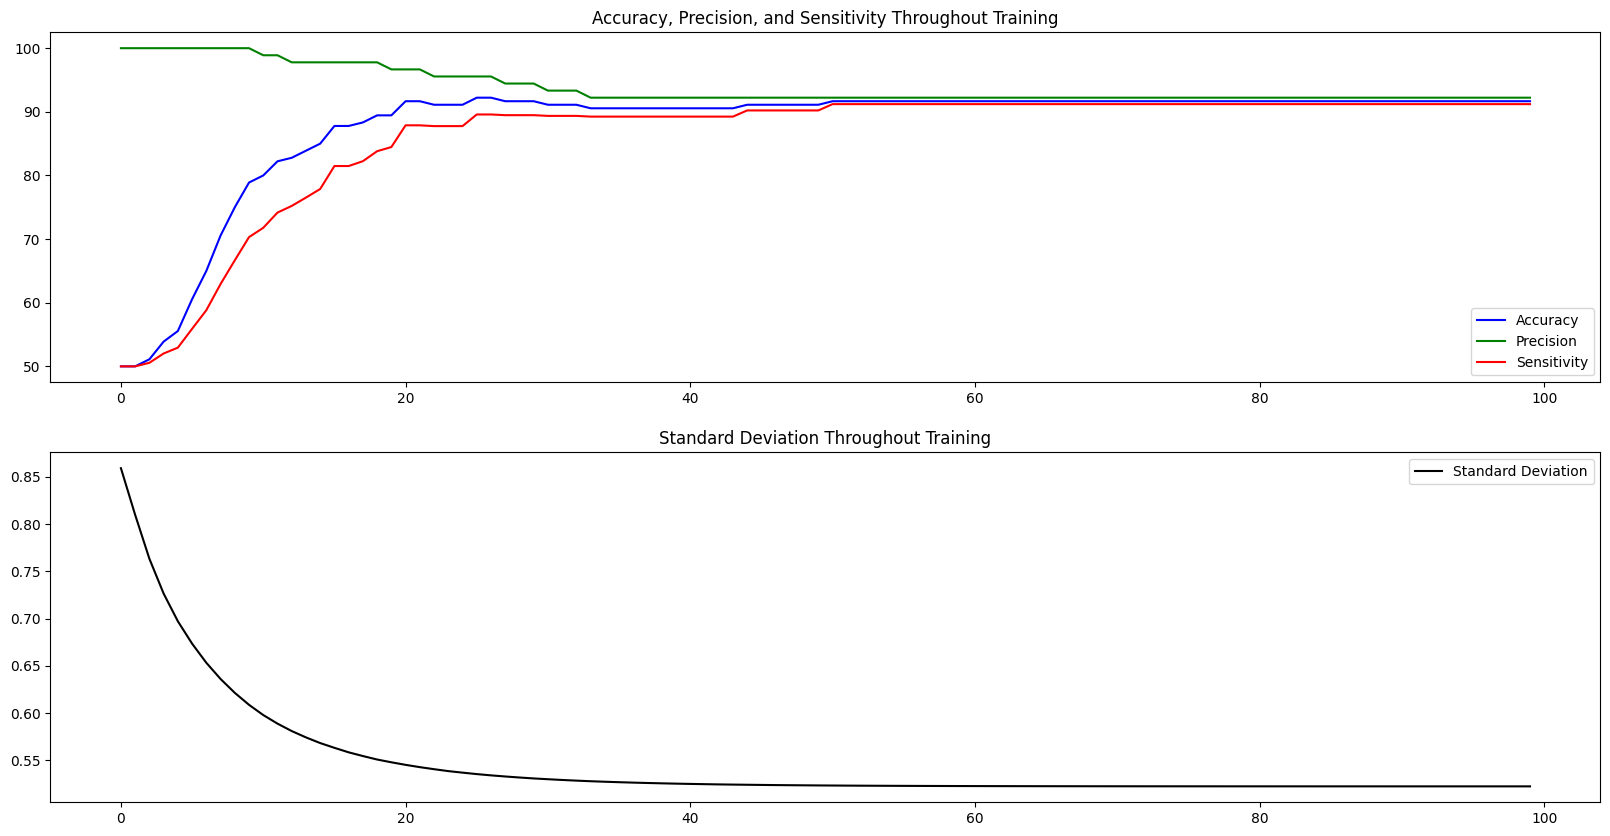

In [19]:
bnn.visualize_model_performance()

# Evaluate Model Performance

In [29]:
def predict_on_data(feature, target):
    mean_pred = []
    var_pred = []
    
    for feature_data_i in feature.reshape(-1, 2, 1):
        _, _, _, _, _, _, _, mz, vz = bnn.bnn_fp.forward_propagation(feature_data_i, bnn.m, bnn.v, bnn.model_structure)
    
        mean_pred.append(mz[-1][0, 0])
        var_pred.append(vz[-1][0, 0])
    
    performance = pd.DataFrame({
                            'Mean Predictions':mean_pred,
                            'Var Predictions':var_pred
                        })
    
    performance['Binary Predictions'] = bnn.bnn_fp._binary_classification_output_activation_function(performance['Mean Predictions'].values)
    performance['Actual'] = target

    return performance

In [30]:
on_seen_data = predict_on_data(feature_data_train, target_data_train)
on_unseen_data = predict_on_data(feature_data_test, target_data_test)

In [31]:
tp, fp, fn, tn  = confusion_matrix(on_unseen_data['Binary Predictions'].values, on_unseen_data['Actual'].values, labels=[1, -1]).ravel()

# calculate the evaluation metrics for the model
accuracy = (tp + tn) / (tp + tn + fp + fn) * 100
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100

for eval, text in zip([accuracy, precision, recall], ['Accuracy', 'Precision', 'Recall']):
    print(f'{text} : {np.round(eval, 3)}%')

Accuracy : 95.0%
Precision : 90.909%
Recall : 100.0%


In [32]:
on_unseen_data['Var Predictions'].mean()

0.5345388304562319

In [33]:
on_seen_data['STD Predictions'] = on_seen_data['Var Predictions'] ** 0.5
on_unseen_data['STD Predictions'] = on_unseen_data['Var Predictions'] ** 0.5

In [36]:
on_seen_data['Probability'] = on_seen_data.apply(lambda row: norm.cdf((row['Mean Predictions'] + row['Actual'] * 0.7) / row['STD Predictions']),axis=1)
on_unseen_data['Probability'] = on_unseen_data.apply(lambda row: norm.pdf((row['Mean Predictions'] + row['Actual'] * 0.7) / row['STD Predictions']),axis=1)

In [37]:
on_seen_data.loc[on_seen_data['Actual'] == on_seen_data['Binary Predictions'], :] \
    .sort_values('Probability', ascending=False)

,Mean Predictions,Var Predictions,Binary Predictions,Actual,STD Predictions,Probability
56,0.189692,0.729758,1,1.0,0.854259,0.851173
19,0.189540,0.729879,1,1.0,0.854329,0.851112
22,0.180923,0.715809,1,1.0,0.846055,0.851111
8,0.190635,0.732193,1,1.0,0.855683,0.851027
17,0.216441,0.775284,1,1.0,0.880502,0.851020
...,...,...,...,...,...,...
98,-0.272713,0.279476,-1,-1.0,0.528655,0.032886
127,-0.282975,0.276169,-1,-1.0,0.525518,0.030708
123,-0.284167,0.274021,-1,-1.0,0.523470,0.030048
95,-0.288085,0.272020,-1,-1.0,0.521555,0.029080


In [26]:
on_seen_data.loc[on_seen_data['Actual'] != on_seen_data['Binary Predictions'], :] \
    .sort_values('Probability')

,Mean Predictions,Var Predictions,Binary Predictions,Actual,STD Predictions,Probability
84,-0.010041,0.471950,-1,1.0,0.686986,0.240924
53,-0.014043,0.468052,-1,1.0,0.684143,0.241329
2,-0.019616,0.462368,-1,1.0,0.679977,0.241826
40,-0.035112,0.447863,-1,1.0,0.669226,0.243539
24,-0.045956,0.438154,-1,1.0,0.661932,0.244854
156,0.009766,0.492858,1,-1.0,0.702038,0.246039
138,0.010500,0.500812,1,-1.0,0.707681,0.248186
18,-0.105871,0.386250,-1,1.0,0.621490,0.252617
28,-0.132759,0.366193,-1,1.0,0.605139,0.257105
101,0.043240,0.531433,1,-1.0,0.728994,0.265867
